In [12]:
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
import plotly.graph_objs as go
import json
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import os

# import dash
# import dash_core_components as dcc
# import dash_html_components as html
# from dash.dependencies import Input, Output

# %matplotlib qt


In [3]:
def load_files(relative_folder='04-04\lidar_logs', target_time='62_8', window_files=5):
    column_names = ['x', 'y', 'z']
    dfs_by_filename = {}
    target_folder = r"C:\Users\Nefelie\OneDrive - University of Southampton\Uni\4th Year\GDP\LINUX"
    target_folder = f"{target_folder}\{relative_folder}"
    
    # Extract target index and time
    target_index, target_timestamp = map(int, target_time.split('_'))
    
    # Get a list of all files in the directory
    all_files = os.listdir(target_folder)
    
    # Sort the filenames by their time stamp
    sorted_files = sorted(all_files, key=lambda x: (int(x.split('_')[0]), int(x.split('_')[1])))
    
    # Find the index of the target time in the sorted list
    target_index_in_sorted = sorted_files.index(target_time)
    
    # Calculate the lower and upper indices for the window
    lower_index = max(0, target_index_in_sorted - window_files)
    upper_index = min(len(sorted_files), target_index_in_sorted + window_files + 1)
    
    # Extract the filenames within the window around the target time
    files_within_window = sorted_files[lower_index:upper_index]
    
    # Load data from the selected files
    for filename in files_within_window:
        file_path = os.path.join(target_folder, filename)
        df = pd.read_csv(file_path, names=column_names)
        df['time'] = int(filename.split('_')[1])  # Assign time from filename
        dfs_by_filename[filename] = df
    
    return dfs_by_filename

# Example usage

def extract_dfs(relative_folder='\04-04\lidar_logs', target_time='1_052', window_files=5):

    dfs_by_filename = load_files(relative_folder, target_time, window_files)

    # Accessing DataFrame for each filename
    for filename, df in dfs_by_filename.items():
        print(f"Filename: {filename}")
        # print(df)


    # Extracting DataFrames from the dictionary
    dfs_list = list(dfs_by_filename.values())

    # Concatenating DataFrames
    combined_df = pd.concat(dfs_list, ignore_index=True)

    return dfs_list, combined_df


In [4]:
def plot_all_dfs(dfs_by_filename):

    import matplotlib.pyplot as plt
    # Plotting each DataFrame separately with different colors
    for i, (filename, df) in enumerate(dfs_by_filename.items()):
        plt.plot(-df['y'], df['x'], "o", markersize=5, label=filename)

    plt.axis("equal")
    plt.legend()
    plt.show()

## WORKING SAVING SELECTED DATA

In [19]:
relative_folder=r'19-04\0.9 MP\lidar_logs'
target_time='2_152'
window_files=3
dfs_by_filename = load_files(relative_folder, target_time, window_files)
dfs_list, combined_df = extract_dfs(relative_folder, target_time, window_files)
plot_all_dfs(dfs_by_filename)


Filename: 2_3
Filename: 2_4
Filename: 2_052
Filename: 2_152


In [21]:
df_select = combined_df[["x", "y", "z"]]

cars = df_select.copy()

# Initialize global variable to store selected data
selected_data_global = pd.DataFrame(columns=['x', 'y'])

# Build simple Dash Layout
app = dash.Dash(__name__)

app.layout = html.Div([
    html.Button(id='ignore', style={'display': 'none'}),  # Create a hidden button just so the first callback will have an input. It doesn't do anything.
    dcc.Graph(id='carGraph', config={'scrollZoom': True}),  # Graph that displays all data
    html.Div(id='display'),  # To show format of selectData
    dcc.Graph(id='filterGraph', config={'scrollZoom': True}),  # Graph that shows only filtered data
    # Hidden div to store selected data
    html.Div(id='selected-data', style={'display': 'none'})
])

# Create graph with data
@app.callback(Output('carGraph', 'figure'), [Input('ignore', 'n_clicks')])
def testfunc(clicks):
    trace1 = go.Scattergl(x=-cars['y'], y=cars['x'], mode='markers')
    layout = go.Layout(title='All Data', xaxis=dict(scaleanchor="y", scaleratio=1), yaxis=dict(scaleanchor="x", scaleratio=1), dragmode="lasso")
    return {'data': [trace1], 'layout': layout}

# Extract the selected data and store it in a global variable
@app.callback(Output('selected-data', 'children'), [Input('carGraph', 'selectedData')])
def saveSelectedData(selectData):
    global selected_data_global
    if selectData is None or 'points' not in selectData:
        return json.dumps(selected_data_global.to_dict(orient='split'))  # Return current selection if no new selection
    else:
        selected_points = selectData['points']
        selected_new = pd.DataFrame({
            'x': [point['y'] for point in selected_points],  # Swapping 'y' and 'x'
            'y': [point['x'] for point in selected_points]   # Swapping 'x' and 'y'
        })
        selected_data_global = pd.concat([selected_data_global, selected_new]).drop_duplicates()
        return json.dumps(selected_data_global.to_dict(orient='split'))

@app.callback(Output('filterGraph', 'figure'), [Input('selected-data', 'children')])
def filterData(selectedData):
    if selectedData is None:
        return {'data': [], 'layout': {}}

    selected_df = pd.read_json(selectedData, orient='split')

    trace2 = go.Scattergl(x=-selected_df['y'], y=selected_df['x'], mode='markers')
    layout2 = go.Layout(title='Selected Data', xaxis=dict(scaleanchor="y", scaleratio=1), yaxis=dict(scaleanchor="x", scaleratio=1))

    return {'data': [trace2], 'layout': layout2}

if __name__ == '__main__':
    app.run_server(debug=True)


In [22]:
plt.figure(dpi=200)
plt.scatter(selected_data_global.y, selected_data_global.x, s=2)

selected_data_global.to_pickle(f"{relative_folder}\{target_time}_filtered.pkl")


In [13]:
relative_folder=r'19-04\0.9 MP\lidar_logs'
target_time='2_152'
selected_data_global = pd.read_pickle(f"{relative_folder}\{target_time}_filtered.pkl")


In [14]:
def generate_clusters(selected_data_global):
    # Standardize the data
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(selected_data_global)

    # Using DBSCAN for clusteringS
    dbscan = DBSCAN(eps=0.15, min_samples=1)  # Adjust parameters as needed
    clusters = dbscan.fit_predict(df_scaled)

    # fig = plt.figure(dpi=200)
    # ax = fig.add_subplot(111)
    # ax.scatter(selected_data_global['y'], selected_data_global['x'], c=clusters, cmap='prism', s=1)

    return clusters


In [32]:
%matplotlib inline
# Calculate the distance of a point (x, y) to the origin (0, 0)
def distance_to_origin(x, y):
    return np.sqrt(x**2 + y**2)


def get_min_cluster_distance(clusters):
    # Create a DataFrame to store the minimum distance for each cluster
    min_distances = pd.DataFrame(index=np.unique(clusters), columns=['min_distance'])

    # Iterate over each cluster
    for cluster_label in np.unique(clusters):
        if cluster_label == -1:  # Ignore noise points (-1 label by DBSCAN)
            continue
        
        # Filter the data points belonging to the current cluster
        cluster_points = selected_data_global[clusters == cluster_label].copy()  # Make a copy to avoid the warning
        
        # Calculate the distance of each point in the cluster to the origin
        cluster_points['distance_to_origin'] = distance_to_origin(cluster_points['x'], cluster_points['y'])
        
        # Find the minimum distance for this cluster
        min_distance = cluster_points['distance_to_origin'].min()
        
        # Store the minimum distance for this cluster
        min_distances.loc[cluster_label, 'min_distance'] = min_distance  # Use .loc for assignment


    # Print or use min_distances DataFrame as needed
    print(min_distances)

    fig = plt.figure(figsize=(4,4), dpi=200)
    plt.rc('font', size=10)

    ax = fig.add_subplot(111)
    scatter = ax.scatter(selected_data_global['y'], selected_data_global['x'], c=clusters, cmap='turbo', s=1)

    # Plotting cluster centroids with corresponding minimum distances
    for cluster_label in np.unique(clusters):
        if cluster_label == -1:  # Ignore noise points
            continue
        
        # Get the centroid of the cluster
        centroid = selected_data_global.loc[clusters == cluster_label, ['y', 'x']].mean()
        
        # Get the corresponding minimum distance
        min_distance = min_distances.loc[cluster_label, 'min_distance']
        
        # Get the color of the cluster
        cluster_color = scatter.to_rgba(cluster_label)
        
        # Annotate the centroid with cluster label and minimum distance
        ax.text(centroid['y']+6, centroid['x']-6, f"Cluster {cluster_label+1}:\n{min_distance:.1f}m", 
                color=cluster_color)
        ax.set_xlabel("X (m)")
        ax.set_ylabel("Y (m)")

    plt.xlim(-60,40)
    plt.ylim(0, 150)

    plt.show()

    return min_distances


  min_distance
0   137.125518
1    58.348909
2   100.143357
3   120.192861
4     8.077306
5    23.426513
6     83.74311


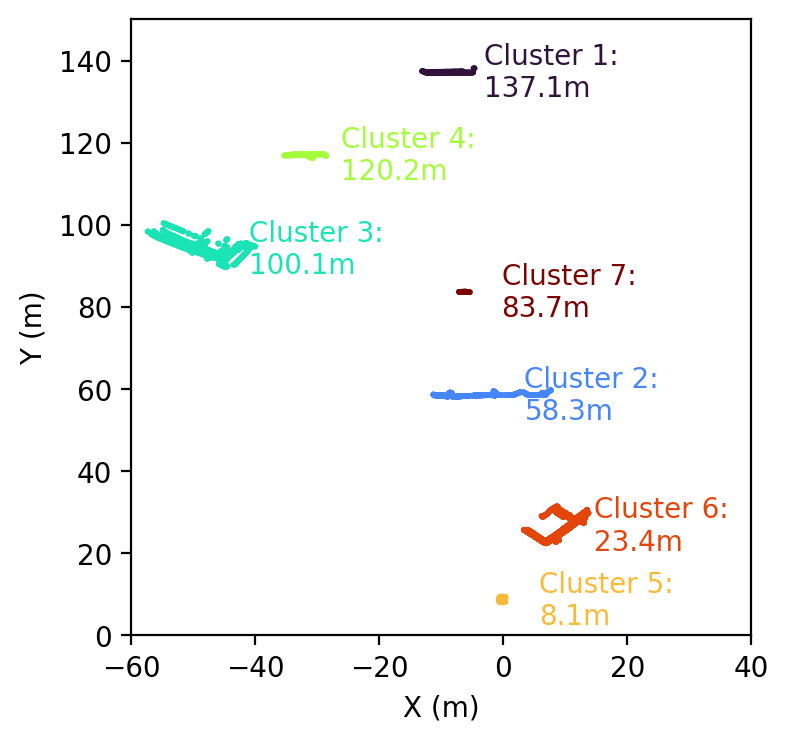

In [33]:
clusters = generate_clusters(selected_data_global)
min_distances = get_min_cluster_distance(clusters)

In [10]:
def percentage_error(actual, measured):
    """
    Calculate the percentage error between the actual value and the measured value.

    Parameters:
        actual (float): The actual value.
        measured (float): The measured value.

    Returns:
        float: The percentage error.
    """
    error = abs(actual - measured)
    percentage_error = (error / actual) * 100
    return percentage_error

# Example usage:
actual_value = 47.93
measured_value = 42
error = percentage_error(actual_value, measured_value)
print("Percentage Error:", error)


Percentage Error: 12.372209472146881
